# BBC Visual and Data Journalism Cookbook for Lets-Plot

The notebook is based on [this page](https://bbc.github.io/rcookbook/index.html).

Data is extracted from the [gapminder](https://cran.r-project.org/web/packages/gapminder/README.html) R package.

In [1]:
import pandas as pd

from lets_plot import *
from lets_plot.mapping import as_discrete


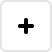
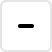
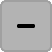
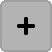
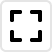
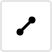
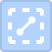
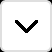
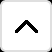
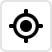
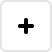
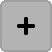
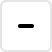
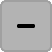
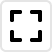
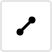
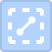
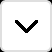
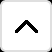
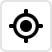

In [2]:
LetsPlot.setup_html()

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/data/gapminder.csv")
df.head()

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106


In [4]:
line_size = 1.1

def bbc_theme(show_x_axis=True, axis_x_margin=[20, 20]):
    def get_element_text(title=False, subtitle=False):
        face = None
        size = 21
        margin = None
        if title:
            size = 33
            face = "bold"
        if subtitle:
            size = 26
            margin = [9, 0, 0, 0]
        return element_text(family="Helvetica", face=face, size=size, margin=margin)
    return theme(
        plot_title=get_element_text(title=True),
        plot_subtitle=get_element_text(subtitle=True),
        legend_position='top',
        legend_background='blank',
        legend_title='blank',
        legend_text=get_element_text(),
        axis_title='blank',
        axis_text=get_element_text(),
        axis_text_x=element_text(margin=axis_x_margin),
        axis_text_y=element_text(margin=[10, 5]),
        axis_ticks='blank',
        axis_line=element_line(size=2*line_size) if show_x_axis else 'blank',
        axis_ontop_x=True,
        panel_grid_minor='blank',
        panel_grid_major_y=element_line(size=1.2, color='#CBCBCB'),
        panel_grid_major_x='blank',
        panel_background='blank',
        strip_text=element_text(size=26, hjust=0)
    )

## Make a line chart

In [5]:
line_df = df[df.country == "Malawi"]

ggplot(line_df, aes('year', 'lifeExp')) + \
    geom_line(color='#1380A1', size=line_size, \
              tooltips=layer_tooltips().format("@year", "d")) + \
    scale_x_continuous(format='d') + \
    scale_y_continuous(limits=[0, 52], expand=[0, 0]) + \
    bbc_theme() + \
    labs(title="Living longer", subtitle="Life expectancy in Malawi 1952-2007")

In [6]:
line_df = df[df.country == "China"]

ggplot(line_df, aes('year', 'lifeExp')) + \
    geom_line(color='#1380A1', size=line_size, \
              tooltips=layer_tooltips().format("@year", "d")) + \
    scale_x_continuous(format='d') + \
    scale_y_continuous(limits=[0, 75], expand=[0, 0]) + \
    bbc_theme() + \
    labs(title="Living longer", subtitle="Life expectancy in China 1952-2007")

## Make a multiple line chart

In [7]:
multiple_line_df = df[df.country.isin(["China", "United States"])]

multiple_line_plot = ggplot(multiple_line_df, aes('year', 'lifeExp', color='country')) + \
    geom_line(size=line_size, tooltips=layer_tooltips().format("@year", "d")) + \
    scale_x_continuous(format='d') + \
    scale_y_continuous(limits=[0, 85], expand=[0, 0]) + \
    scale_color_manual(values=['#FAAB18', '#1380A1']) + \
    bbc_theme() + \
    labs(title="Living longer", subtitle="Life expectancy in China and the US")
multiple_line_plot

## Add color scheme (flavor)

In [8]:
multiple_line_plot + ggsize(700, 450) + theme(plot_margin=[20, 30]) + flavor_high_contrast_dark()

## Make a bar chart

In [9]:
bar_df = df[(df.year == 2007)&(df.continent == "Africa")]\
           .sort_values(by=['lifeExp'], ascending=False).head(5)

bars_plot = ggplot(bar_df, aes(as_discrete('country', order=1), 'lifeExp')) + \
    geom_bar(stat='identity', position='identity', fill='#1380A1') + \
    scale_y_continuous(limits=[0, 82]) + \
    bbc_theme() + \
    ggsize(640, 480) + \
    labs(title="Reunion is highest", subtitle="Highest African life expectancy, 2007")
bars_plot

## Make a stacked bar chart

In [10]:
stacked_df = df[df.year == 2007].assign(
    lifeExpGrouped=lambda df: pd.cut(
        df.lifeExp, bins=pd.IntervalIndex.from_tuples([(0, 50), (50, 65), (65, 80), (80, 90)])
    ).cat.rename_categories(["Under 50", "50-65", "65-80", "80+"])
).rename(
    columns={'pop': 'continentPop'}
).groupby(['continent', 'lifeExpGrouped'], observed=False).continentPop.sum().reset_index().query('continentPop > 0').assign(
    continentPopPercentage=lambda df: 100 * df.groupby('continent', group_keys=True).continentPop.apply(
        lambda x: x / float(x.sum())
    ).values
)

ggplot(stacked_df, aes('continent', 'continentPopPercentage', fill='lifeExpGrouped')) + \
    geom_bar(stat='identity', size=0, tooltips=layer_tooltips().line('@continentPop')\
                                                               .format('@continentPop', ',d')) + \
    bbc_theme() + \
    scale_y_continuous(breaks=list(range(0, 101, 25)), format='{d}%') + \
    scale_fill_viridis() + \
    labs(title="How life expectancy varies", subtitle="% of population by life expectancy band, 2007")

## Make a grouped bar chart

In [11]:
grouped_bar_df = pd.melt(
    df[df.year.isin([1967, 2007])][['country', 'year', 'lifeExp']].pivot(
        index='country', columns='year', values='lifeExp'
    ).assign(
        gap=lambda df: df[2007] - df[1967]
    ).sort_values(
        by='gap', ascending=False
    ).head(5).reset_index(),
    id_vars=['country', 'gap'],
    value_vars=[1967, 2007],
    value_name='lifeExp'
)

ggplot(grouped_bar_df, aes(as_discrete('country', order=1), 'lifeExp', \
                           group='year', fill=as_discrete('year'))) + \
    geom_bar(stat='identity', position='dodge') + \
    bbc_theme() + \
    scale_fill_manual(values=['#1380A1', '#FAAB18']) + \
    ggsize(720, 480) + \
    labs(title="We're living longer", subtitle="Biggest life expectancy rise, 1967-2007")

## Make a dumbbell chart

In [12]:
dumbbell_df = df[df.year.isin([1967, 2007])][['country', 'year', 'lifeExp']].pivot(
    index='country', columns='year', values='lifeExp'
).assign(
    gap=lambda df: df[2007] - df[1967]
).sort_values(
    by='gap'
).tail(10).reset_index()
dumbbell_df.columns = dumbbell_df.columns.map(str)

ggplot(dumbbell_df) + \
    geom_segment(aes(x='1967', xend='2007', y='country', yend='country'), \
                 color='#DDDDDD', size=3) + \
    geom_point(aes(x='1967', y='country'), color='#FAAB18', size=5) + \
    geom_point(aes(x='2007', y='country'), color='#1380A1', size=5) + \
    bbc_theme(show_x_axis=False, axis_x_margin=[5, 10]) + \
    ggsize(640, 400) + \
    labs(title="We're living longer", subtitle="Biggest life expectancy rise, 1967-2007")

## Make a histogram

In [13]:
hist_df = df[df.year == 2007]

breaks = list(range(40, 91, 10))
labels = ['{0} years'.format(y) if y == 90 else str(y) for y in breaks]

ggplot(hist_df, aes('lifeExp')) + \
    geom_histogram(binwidth=5, color='white', fill='#1380A1') + \
    bbc_theme() + \
    scale_x_continuous(limits=[35, 95], breaks=breaks, labels=labels) + \
    labs(title = "How life expectancy varies", subtitle="Distribution of life expectancy in 2007")

## Make changes to the legend

### Remove the legend

In [14]:
multiple_line_plot + scale_color_manual(values=['#FAAB18', '#1380A1'], guide='none')

In [15]:
multiple_line_plot + theme(legend_position='none')

### Change the position of the legend

In [16]:
multiple_line_plot + theme(legend_position='right')

## Make changes to the axes

### Flip the coordinates of a plot

In [17]:
bars_plot = bars_plot + coord_flip()
bars_plot

### Change the plot limits

In [18]:
bars_plot + ylim(0, 500)

### Change the axis text manually

In [19]:
breaks = list(range(0, 81, 20))
labels = ['{0} years'.format(y) if y == 80 else str(y) for y in breaks]

bars_plot = bars_plot + \
    scale_y_continuous(limits=[0, 85], breaks=breaks, labels=labels)
bars_plot

### Add axis ticks

In [20]:
multiple_line_plot + \
    scale_y_continuous(breaks=breaks) + \
    theme(axis_ticks_x=element_line(color='#333333'), axis_ticks_length_x=10)

## Add annotations

### Add an annotation

In [21]:
multiple_line_plot + \
    geom_text(x=1980, y=45, label="I'm an annotation!", \
              hjust=0, vjust=0.5, color='#555555', fill='white', \
              family="Helvetica", size=10, tooltips='none')

In [22]:
multiple_line_plot = multiple_line_plot + \
    geom_text(x=1980, y=45, label="I'm quite a long\nannotation over\nthree rows", \
              hjust=0, vjust=0.5, color='#555555', fill='white', \
              family="Helvetica", size=10, tooltips='none') + \
    theme(legend_position='none') + \
    xlim(1950, 2011) + \
    geom_text(x=2007, y=79, label="US", \
              hjust=0, vjust=0.5, color='#1380A1', fill='white', \
              family="Helvetica", size=10, tooltips='none') + \
    geom_text(x=2007, y=72, label="China", \
              hjust=0, vjust=0.5, color='#FAAB18', fill='white', \
              family="Helvetica", size=10, tooltips='none')
multiple_line_plot

### Add labels based on your data

In [23]:
bars_plot + \
    geom_text(aes('country', 'lifeExp', label='lifeExp'), \
              label_format='d', hjust=1, nudge_y=-1.5, color='white', \
              family="Helvetica", size=10)

### Add left-aligned labels to bar charts

In [24]:
bars_plot + \
    geom_text(aes(x='country', label='lifeExp'), y=4, \
              label_format='d', hjust=0, color='white', \
              family="Helvetica", size=10)

### Add a line

In [25]:
multiple_line_plot + \
    geom_segment(x=1979, y=45, xend=1965, yend=43, color='#555555', size=.5, tooltips='none')

### Add a curved line

In [26]:
multiple_line_plot + \
    geom_curve(x=1979, y=45, xend=1965, yend=43, color='#555555', \
               curvature = -0.2, size=.5, tooltips='none')

### Add an arrow

In [27]:
multiple_line_plot + \
    geom_curve(x=1979, y=45, xend=1965, yend=43, color='#555555', \
               curvature = -0.2, size=.5, arrow=arrow(), tooltips='none')

### Add a line across the whole plot

In [28]:
multiple_line_plot + \
    geom_hline(yintercept=10, size=line_size, color='red', linetype='dashed', tooltips='none')

## Work with small multiples

### Facets

In [29]:
facet_df = df[df.continent != "Americas"].groupby(['continent', 'year']).pop.sum().to_frame().reset_index()

ggplot() + \
    geom_area(aes('year', 'pop', fill='continent'), data=facet_df, size=0) + \
    scale_fill_manual(values=['#FAAB18', '#1380A1', '#990000', '#588300']) + \
    facet_wrap('continent', ncol=5) + \
    scale_y_continuous(breaks=[0, 2000000000, 4000000000], \
                       labels=['0', '2bn', '4bn'], \
                       limits=[0, 4000000010]) + \
    bbc_theme() + \
    theme(legend_position='none', axis_text_x=element_blank()) + \
    ggsize(640, 400) + \
    labs(title="Asia's rapid growth", subtitle="Population growth by continent, 1952-2007")

### Free scales

In [30]:
ggplot() + \
    geom_area(aes('year', 'pop', fill='continent'), data=facet_df, size=0) + \
    scale_fill_manual(values=['#FAAB18', '#1380A1', '#990000', '#588300']) + \
    facet_wrap('continent', scales='free') + \
    bbc_theme() + \
    theme(legend_position='none', axis_text_x=element_blank(), axis_text_y=element_blank()) + \
    ggsize(640, 400) + \
    labs(title="It's all relative", subtitle="Relative population growth by continent, 1952-2007")

## Do something else entirely

### Increase or decrease margins

In [31]:
bars_plot + theme(plot_subtitle=element_text(margin=[0, 0, 75, 0]))

### Reorder bars by size

In [32]:
ggplot(bar_df, aes(as_discrete('country', order_by='lifeExp', order=1), 'lifeExp')) + \
    geom_bar(stat='identity', position='identity', fill='#1380A1') + \
    scale_y_continuous(breaks=list(range(0, 81, 20)), limits=[0, 82]) + \
    bbc_theme() + \
    coord_flip() + \
    labs(title="Reunion is highest", subtitle="Highest African life expectancy, 2007")

### Colour bars conditionally

In [33]:
colored_bar_df = bar_df.assign(color=bar_df["country"].replace(regex={
    r'^Mauritius$': "#1380A1", r'^(?!.*Mauritius).*$': "#DDDDDD"
}))

ggplot(colored_bar_df, aes(as_discrete('country', order_by='lifeExp', order=1), 'lifeExp')) + \
    geom_bar(aes(fill='color'), stat='identity', position='identity') + \
    scale_y_continuous(breaks=list(range(0, 81, 20)), limits=[0, 82]) + \
    scale_fill_identity() + \
    bbc_theme() + \
    coord_flip() + \
    labs(title="Reunion is highest", subtitle="Highest African life expectancy, 2007")